In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using matplotlib backend: MacOSX


莺尾花数据集，当前选取后面两个维度。莺尾花分为以下三类。

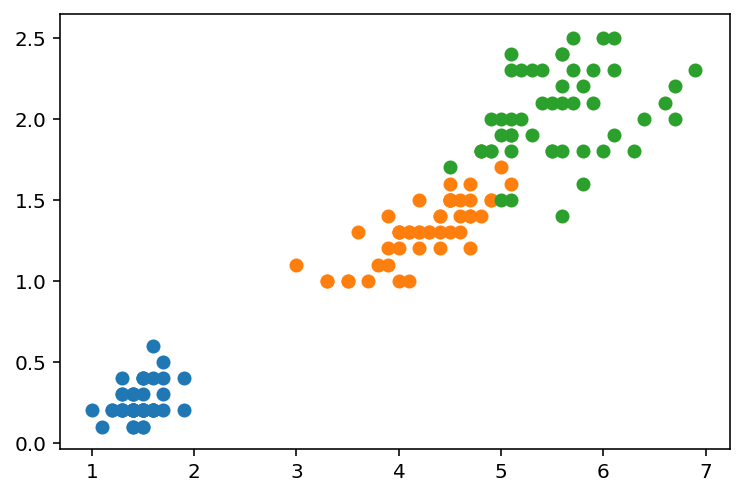

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
x = iris.data[:, 2:]
y = iris.target

plt.scatter(x[y==0,0], x[y==0,1])
plt.scatter(x[y==1,0], x[y==1,1])
plt.scatter(x[y==2,0], x[y==2,1])
plt.show()

## 初探决策树

In [3]:
def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, cmap=custom_cmap)

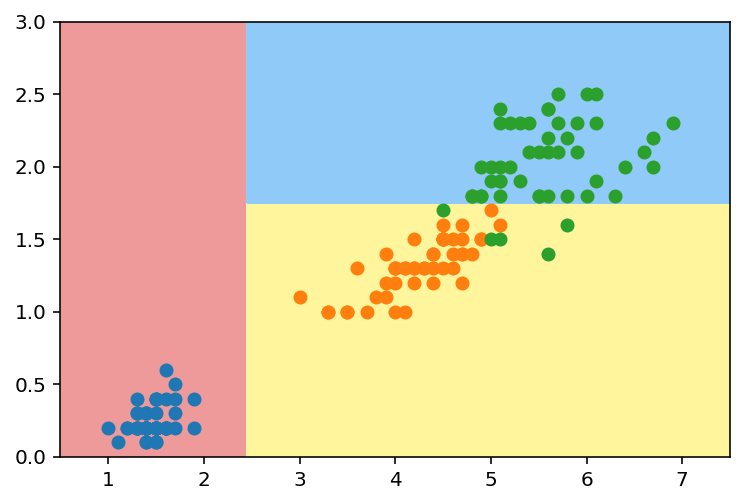

In [4]:
from sklearn.tree import DecisionTreeClassifier


dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy", random_state=42)
dt_clf.fit(x, y)

plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(x[y==0,0], x[y==0,1])
plt.scatter(x[y==1,0], x[y==1,1])
plt.scatter(x[y==2,0], x[y==2,1])
plt.show()

[Text(133.92000000000002, 181.2, 'X[0] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(66.96000000000001, 108.72, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(200.88000000000002, 108.72, 'X[1] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(133.92000000000002, 36.23999999999998, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(267.84000000000003, 36.23999999999998, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]')]

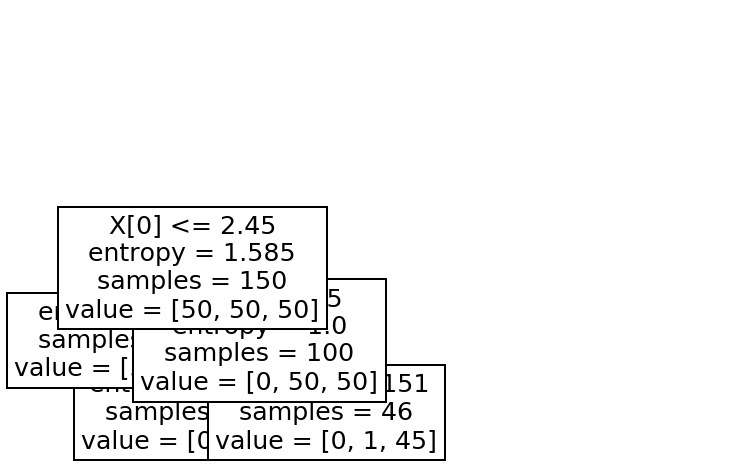

In [5]:
from sklearn.tree import plot_tree

# 绘制决策树
plot_tree(dt_clf) 

## 信息熵
计算公式:
$$
H=-\sum_{i=1}^{k} p_{i} \log \left(p_{i}\right)
$$



### 二分类信息熵
$$
H=-x \log (x)-(1-x) \log (1-x)
$$

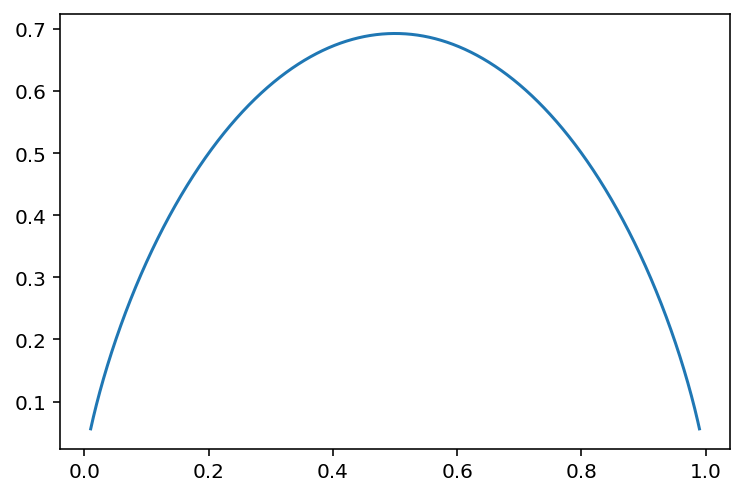

In [41]:
def second_category_entropy(p):
    """二分类问题信息熵"""
    return -p * np.log(p) - (1-p) * np.log(1-p)    

x_tmp = np.linspace(0.01, 0.99, 10000)
y_tmp = second_category_entropy(x_tmp)
plt.plot(x_tmp, y_tmp)

### 信息熵
基于信息熵实现决策树

In [36]:
from collections import Counter

def split(x, y, d, value): 
    left_index = (x[:, d] <= value)
    right_index = (x[:, d] > value)   
    return x[left_index], x[right_index], y[left_index], y[right_index]

def entropy(y):
    """信息熵"""
    counter = Counter(y)
    result = 0
    for num in counter.values():
        p = num / len(y)
        result += -p * np.log(p)
    return result

def decision_tree(x, y):
    best_entropy = float('inf')
    best_d, best_v = -1, -1
    
    for d in range(x.shape[1]):
        sorted_index = np.argsort(x[:, d])
        for i in range(1, len(x)):
            if x[sorted_index[i-1], d]!=x[sorted_index[i], d]:
                v = (x[sorted_index[i-1], d] + x[sorted_index[i], d]) / 2
                l_x, r_x, l_y, r_y = split(x, y, d, v)
                p_l, p_r = len(l_x)/len(x), len(r_x)/len(x)
                e = p_l * entropy(l_y) + p_r * entropy(r_y)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
    return best_entropy, best_d, best_v            

In [34]:
# 第一层级决策
best_entropy, best_d, best_v = decision_tree(x, y)
print('best_entropy: ', best_entropy)
print('best_d: ', best_d)
print('best_v: ', best_v)

best_entropy:  0.46209812037329684
best_d:  0
best_v:  2.45


结论
1. 信息熵为0.4620
2. best_d=0。因为在莺尾花散点图里使用第0维度绘制x轴，所以第一次决策判断阀值的维度使用第0维度，与sklearn里决策树算法结果一致；
3. best_v=2.45。阀值为2.45，与sklearn里决策树算法结果一致。

In [35]:
# 第二次决策
x1_l, x1_r, y1_l, y1_r = split(x, y, best_d, best_v)

best_entropy2, best_d2, best_v2 = decision_tree(x1_r, y1_r)
print('best_entropy2: ', best_entropy2)
print('best_d2: ', best_d2)
print('best_v2: ', best_v2)

best_entropy2:  0.2147644654371359
best_d2:  1
best_v2:  1.75


In [ ]:
结论
1. 信息熵为0.4620
2. best_d2=1。第1个维度呈现在y轴，与sklearn里决策树算法结果一致；
3. best_v=1.75。阀值为1.75，与sklearn里决策树算法结果一致。

## 基尼系数
计算公式：
$$
G=1-\sum_{i=1}^{k} p_{i}^{2}
$$



### 二分类基尼系数
$$
G=-2 x^{2}+2 x
$$

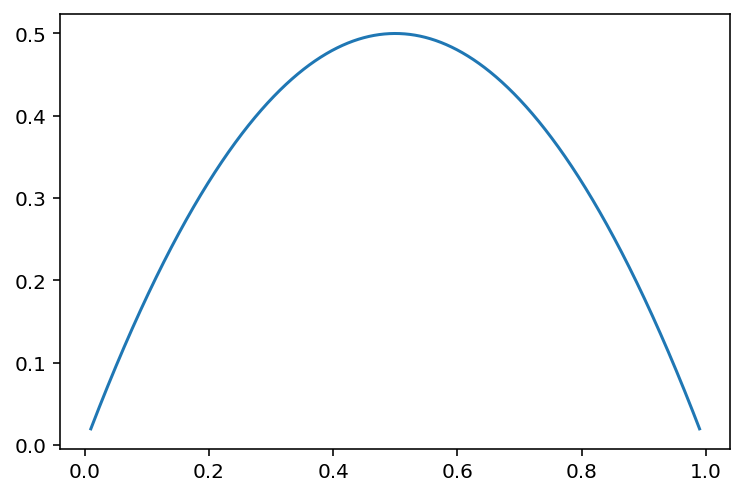

In [40]:
def second_category_gini(p):
    """二分类基尼系数"""
    return -2 * p **2 + 2*p

x_tmp = np.linspace(0.01, 0.99, 1000000)
y_tmp = second_category_gini(x_tmp)
plt.plot(x_tmp, y_tmp)

### 基尼系数
基于基尼系数实现决策树


In [42]:
from collections import Counter

def split(x, y, d, value): 
    left_index = (x[:, d] <= value)
    right_index = (x[:, d] > value)   
    return x[left_index], x[right_index], y[left_index], y[right_index]

def gini(y):
    """信息熵"""
    counter = Counter(y)
    result = 1
    for num in counter.values():
        p = num / len(y)
        result -= p **2
    return result

def decision_tree(x, y):
    best_entropy = float('inf')
    best_d, best_v = -1, -1
    
    for d in range(x.shape[1]):
        sorted_index = np.argsort(x[:, d])
        for i in range(1, len(x)):
            if x[sorted_index[i-1], d]!=x[sorted_index[i], d]:
                v = (x[sorted_index[i-1], d] + x[sorted_index[i], d]) / 2
                l_x, r_x, l_y, r_y = split(x, y, d, v)
                p_l, p_r = len(l_x)/len(x), len(r_x)/len(x)
                e = p_l * gini(l_y) + p_r * gini(r_y)
                if e < best_entropy:
                    best_entropy, best_d, best_v = e, d, v
    return best_entropy, best_d, best_v            

In [43]:
# 第一层级决策
best_entropy, best_d, best_v = decision_tree(x, y)
print('best_entropy: ', best_entropy)
print('best_d: ', best_d)
print('best_v: ', best_v)

best_entropy:  0.3333333333333333
best_d:  0
best_v:  2.45


In [44]:
# 第二次决策
x1_l, x1_r, y1_l, y1_r = split(x, y, best_d, best_v)

best_entropy2, best_d2, best_v2 = decision_tree(x1_r, y1_r)
print('best_entropy2: ', best_entropy2)
print('best_d2: ', best_d2)
print('best_v2: ', best_v2)

best_entropy2:  0.1103059581320451
best_d2:  1
best_v2:  1.75


结论：信息熵与基尼系数求出的结果基本一致。